In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel, WhiteKernel
from mpl_toolkits.mplot3d import Axes3D

def plot_gp_surface(csv_path):
    if not os.path.exists(csv_path):
        print(f"❌ File not found: {csv_path}")
        return

    # Load CSV and drop NaNs
    data = pd.read_csv(csv_path, header=None)
    original_len = len(data)
    data.dropna(inplace=True)
    cleaned_len = len(data)

    if cleaned_len < original_len:
        print(f"⚠️ Dropped {original_len - cleaned_len} rows with NaN values from {csv_path}")

    if data.shape[1] != 3:
        print(f"⚠️ Skipping {csv_path}: Expected 3 columns (x1, x2, y), found {data.shape[1]}")
        return

    X = data.iloc[:, [0, 1]].values
    y = data.iloc[:, 2].values

    if len(X) < 10:
        print(f"⚠️ Not enough clean data points in {csv_path} to build a surface.")
        return

    # Fit Gaussian Process
    kernel = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=1.5) + WhiteKernel()
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
    gp.fit(X, y)

    # Create meshgrid
    x1_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    x2_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
    x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
    X_grid = np.column_stack([x1_grid.ravel(), x2_grid.ravel()])

    y_pred, _ = gp.predict(X_grid, return_std=True)
    y_pred_grid = y_pred.reshape(x1_grid.shape)

    # Find top 2 peaks
    flat_indices = np.argsort(y_pred.ravel())[::-1][:2]
    for i, idx in enumerate(flat_indices, start=1):
        peak_x1 = X_grid[idx, 0]
        peak_x2 = X_grid[idx, 1]
        peak_y = y_pred[idx]
        print(f"🔺 Peak {i}: ({peak_x1:.4f}, {peak_x2:.4f}, {peak_y:.4f})")

    # Plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x1_grid, x2_grid, y_pred_grid, cmap='viridis', edgecolor='none')

    # Annotate the top 2 peaks
    for i, idx in enumerate(flat_indices, start=1):
        px, py = X_grid[idx]
        pz = y_pred[idx]
        ax.scatter(px, py, pz, color='red', s=50)
        ax.text(px, py, pz, f"Peak {i}\n({px:.2f}, {py:.2f}, {pz:.2f})",
                color='red', fontsize=8, ha='left')

    ax.set_title(f"GP Surface Fit: {os.path.basename(csv_path)}")
    ax.set_xlabel('x₁')
    ax.set_ylabel('x₂')
    ax.set_zlabel('Predicted y')

    plt.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Predicted y')
    plt.tight_layout()
    plt.show()



⚠️ Dropped 1 rows with NaN values from data/observations_f1.csv
🔺 Peak 1: (0.0000, 1.0000, 2.0000)
🔺 Peak 2: (0.6333, 0.6299, 1.8838)


C:\Users\satyan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


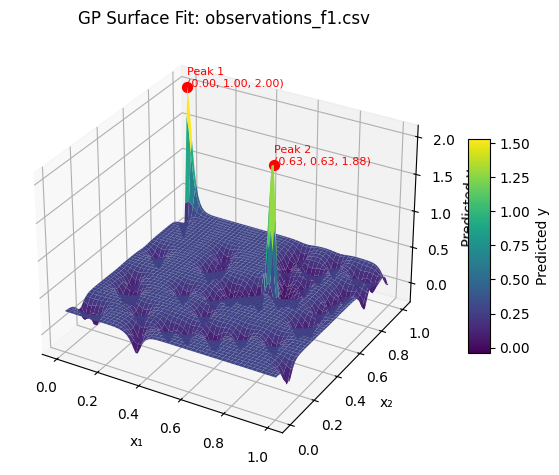

⚠️ Dropped 1 rows with NaN values from data/observations_f2.csv
🔺 Peak 1: (0.0000, 1.0000, 0.8586)
🔺 Peak 2: (0.0101, 1.0000, 0.8512)


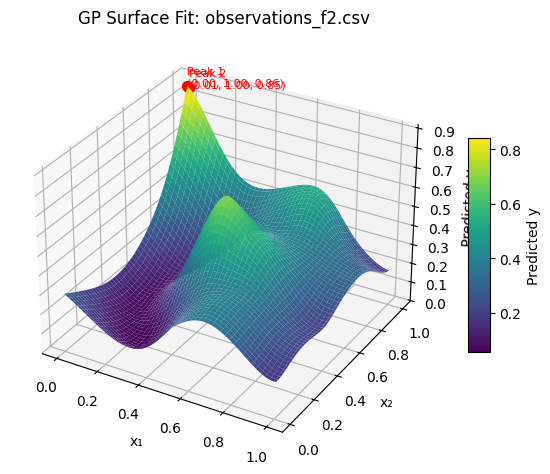

In [2]:
if __name__ == "__main__":
    plot_gp_surface("data/observations_f1.csv")
    plot_gp_surface("data/observations_f2.csv")

In [3]:
!pip install plotly scikit-learn pandas



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import os
import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel, WhiteKernel
import plotly.express as px  # <--- don't override this later

def plot_4d_gp_interactive(csv_path):
    if not os.path.exists(csv_path):
        print(f"❌ File not found: {csv_path}")
        return

    data = pd.read_csv(csv_path, header=None)
    original_len = len(data)
    data.dropna(inplace=True)
    cleaned_len = len(data)

    if cleaned_len < original_len:
        print(f"⚠️ Dropped {original_len - cleaned_len} rows with NaN values")

    if data.shape[1] != 4:
        print(f"⚠️ Expected 4 columns (x1, x2, x3, y), found {data.shape[1]}")
        return

    X = data.iloc[:, [0, 1, 2]].values
    y = data.iloc[:, 3].values

    if len(X) < 10:
        print(f"⚠️ Not enough clean data points to build a surface.")
        return

    kernel = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=1.5) + WhiteKernel()
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
    gp.fit(X, y)

    y_pred, _ = gp.predict(X, return_std=True)

    top_indices = np.argsort(y_pred)[::-1][:2]
    for i, idx in enumerate(top_indices, 1):
        px_, py_, pz_ = X[idx]
        pred_ = y_pred[idx]
        print(f"🔺 Peak {i}: ({px_:.4f}, {py_:.4f}, {pz_:.4f}, Pred y: {pred_:.4f})")

    df_plot = pd.DataFrame(X, columns=["x1", "x2", "x3"])
    df_plot["pred_y"] = y_pred

    fig = px.scatter_3d(
        df_plot, x="x1", y="x2", z="x3", color="pred_y",
        color_continuous_scale='Viridis', title="4D GP Interactive Plot",
        labels={"pred_y": "Predicted y"}
    )

    fig.update_traces(marker=dict(size=5))
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=40))
    fig.show()


⚠️ Dropped 1 rows with NaN values
🔺 Peak 1: (0.0000, 1.0000, 2.0000, Pred y: 2.9998)
🔺 Peak 2: (0.7412, 0.4440, 0.4768, Pred y: 0.0010)


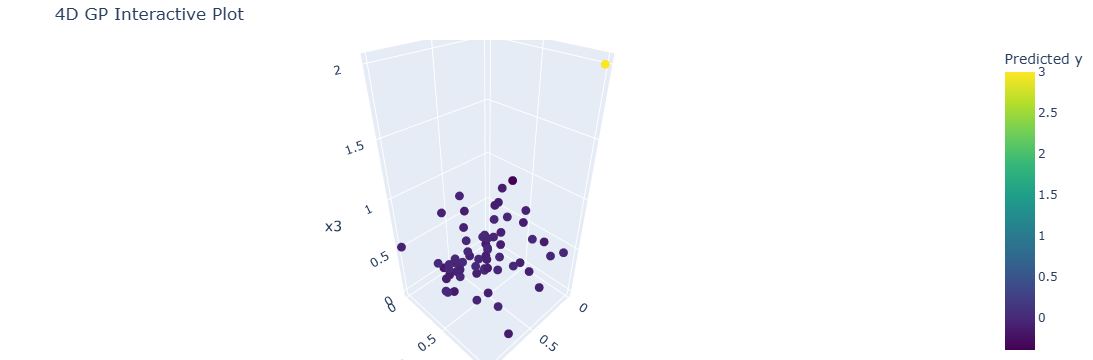

In [8]:
plot_4d_gp_interactive("data/observations_f3.csv")

In [14]:
import os
import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel, WhiteKernel
import plotly.express as px

def plot_5d_gp_interactive(csv_path):
    if not os.path.exists(csv_path):
        print(f"❌ File not found: {csv_path}")
        return

    data = pd.read_csv(csv_path, header=None)
    original_len = len(data)
    data.dropna(inplace=True)
    cleaned_len = len(data)

    if cleaned_len < original_len:
        print(f"⚠️ Dropped {original_len - cleaned_len} rows with NaN values")

    if data.shape[1] != 5:
        print(f"⚠️ Expected 5 columns (x1, x2, x3, x4, y), found {data.shape[1]}")
        return

    # Extract inputs and target
    X = data.iloc[:, [0, 1, 2, 3]].values  # x1 to x4
    y = data.iloc[:, 4].values            # y

    if len(X) < 10:
        print(f"⚠️ Not enough clean data points to build a surface.")
        return

    # Fit Gaussian Process
    kernel = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=1.5) + WhiteKernel()
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
    gp.fit(X, y)

    # Predict on the same input points
    y_pred, _ = gp.predict(X, return_std=True)

    # Find top 2 predictions
    top_indices = np.argsort(y_pred)[::-1][:2]
    for i, idx in enumerate(top_indices, 1):
        px_, py_, pz_, x4_ = X[idx]
        pred_ = y_pred[idx]
        print(f"🔺 Peak {i}: ({px_:.4f}, {py_:.4f}, {pz_:.4f}, x4: {x4_:.4f}, Pred y: {pred_:.4f})")

    # Prepare DataFrame for plotting
    df_plot = pd.DataFrame(X, columns=["x1", "x2", "x3", "x4"])
    df_plot["pred_y"] = y_pred

    # Plot: 3D scatter with color and size
    fig = px.scatter_3d(
        df_plot, x="x1", y="x2", z="x3",
        color="pred_y",
        size="x4",
        color_continuous_scale='Viridis',
        title="5D GP Interactive Plot: x1-x3 (space), x4 (size), y (color)",
        labels={"pred_y": "Predicted y", "x4": "x₄ (Size)"}
    )

    fig.update_traces(marker=dict(sizemin=4))
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=40))
    fig.show()
    fig.write_html("interactive_5d_f5_plot.html")



⚠️ Dropped 1 rows with NaN values
🔺 Peak 1: (0.0000, 1.0000, 2.0000, x4: 3.0000, Pred y: 3.9880)
🔺 Peak 2: (0.4038, 0.3890, 0.3926, x4: 0.4046, Pred y: 0.4377)


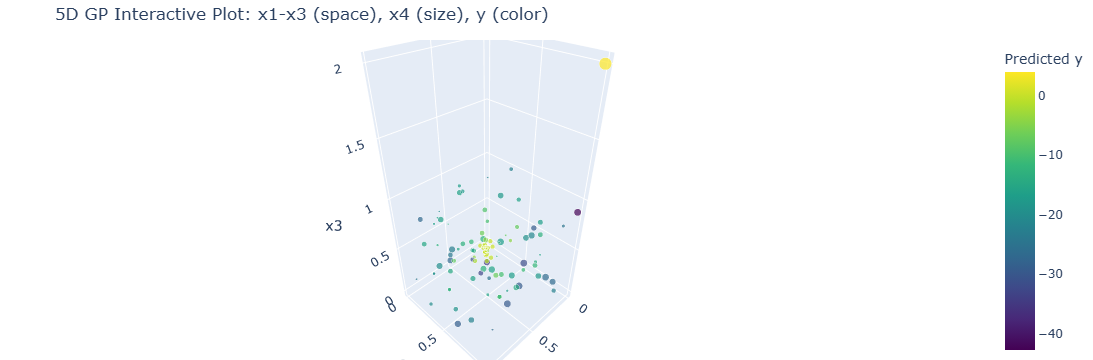

In [13]:
plot_5d_gp_interactive("data/observations_f4.csv")

⚠️ Dropped 1 rows with NaN values
🔺 Peak 1: (1.0000, 1.0000, 1.0000, x4: 1.0000, Pred y: 8656.6297)
🔺 Peak 2: (1.0000, 1.0000, 1.0000, x4: 1.0000, Pred y: 8656.6164)


C:\Users\satyan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.



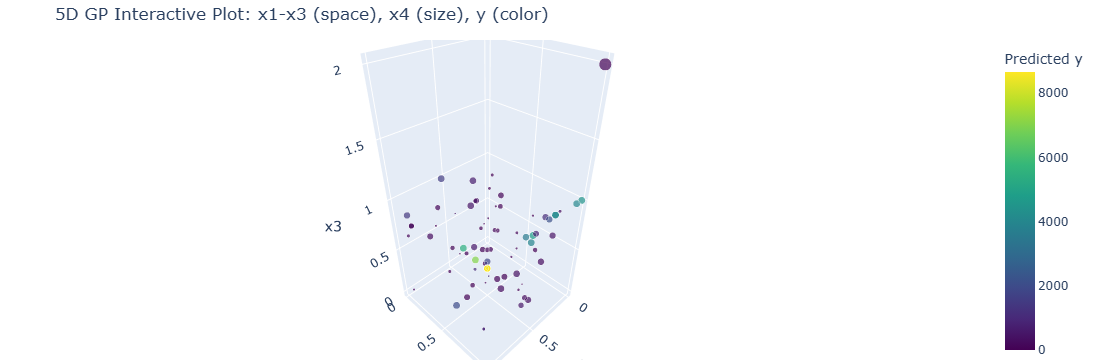

In [15]:
plot_5d_gp_interactive("data/observations_f5.csv")

In [16]:
import os
import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel, WhiteKernel
import plotly.express as px

def plot_6d_gp_interactive(csv_path):
    if not os.path.exists(csv_path):
        print(f"❌ File not found: {csv_path}")
        return

    data = pd.read_csv(csv_path, header=None)
    original_len = len(data)
    data.dropna(inplace=True)
    cleaned_len = len(data)

    if cleaned_len < original_len:
        print(f"⚠️ Dropped {original_len - cleaned_len} rows with NaN values")

    if data.shape[1] != 6:
        print(f"⚠️ Expected 6 columns (x1, x2, x3, x4, x5, y), found {data.shape[1]}")
        return

    # Extract features and target
    X = data.iloc[:, [0, 1, 2, 3, 4]].values  # x1–x5
    y = data.iloc[:, 5].values               # y

    if len(X) < 10:
        print(f"⚠️ Not enough clean data points to build a surface.")
        return

    # Fit Gaussian Process
    kernel = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=1.5) + WhiteKernel()
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
    gp.fit(X, y)

    y_pred, _ = gp.predict(X, return_std=True)

    # Find top 2 predictions
    top_indices = np.argsort(y_pred)[::-1][:2]
    for i, idx in enumerate(top_indices, 1):
        px_, py_, pz_, x4_, x5_ = X[idx]
        pred_ = y_pred[idx]
        print(f"🔺 Peak {i}: ({px_:.4f}, {py_:.4f}, {pz_:.4f}, x4: {x4_:.4f}, x5: {x5_:.4f}, Pred y: {pred_:.4f})")

    # Prepare DataFrame
    df_plot = pd.DataFrame(X, columns=["x1", "x2", "x3", "x4", "x5"])
    df_plot["pred_y"] = y_pred

    # Bin x5 for animation
    df_plot["x5_bin"] = pd.qcut(df_plot["x5"], q=5, labels=[f"Bin {i}" for i in range(1, 6)])

    # Plot: 3D scatter with color and size, animated by x5
    fig = px.scatter_3d(
        df_plot, x="x1", y="x2", z="x3",
        color="pred_y",
        size="x4",
        animation_frame="x5_bin",
        color_continuous_scale='Viridis',
        title="6D GP Interactive Plot: 3D + Color(y) + Size(x4) + Animation(x5)",
        labels={"pred_y": "Predicted y", "x4": "x₄ (size)", "x5_bin": "x₅ (animation)"}
    )

    fig.update_traces(marker=dict(sizemin=4))
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=40))
    fig.show()
    fig.write_html("interactive_6d_plot.html")


⚠️ Dropped 1 rows with NaN values
🔺 Peak 1: (0.0000, 1.0000, 2.0000, x4: 3.0000, x5: 4.0000, Pred y: 4.9973)
🔺 Peak 2: (0.3807, 0.3480, 0.6300, x4: 0.7436, x5: 0.1245, Pred y: -0.1183)


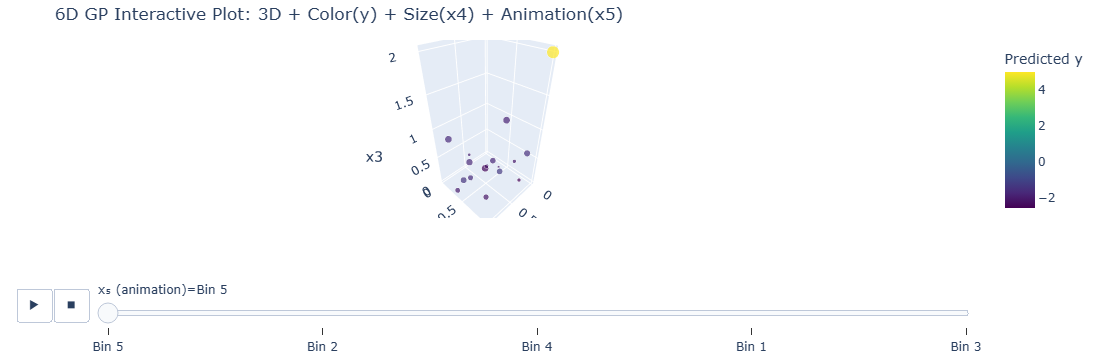

In [17]:
plot_6d_gp_interactive("data/observations_f6.csv")